# reduced classes experiments for 1/K labelling

In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import RandomForestClassifier as RF
import time
from numpy.random import *

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action = 'ignore', category = FutureWarning)

In [2]:
def randints_nodup(k):
    ns = []
    while (len(ns) < k):
        n = randint(0, 10)
        if not n in ns:
            ns.append(n)
    return list(ns) 

In [10]:
# 1/K labelling
def oneKth_label(probas, s_cls):
    # 1/K
    thrshld = 1/len(s_cls)
    labels = np.array([s_cls[i] for i, pk in enumerate(probas) if pk > thrshld])

    return labels

In [4]:
# duplicating images k-1 times, for k-labels
def dup_imgs(img, labels):
    k = len(labels)
    if k == 1:
        #print(img.shape)
        return np.array(img)
    else:
        tmp_dup = np.array([img for _ in range(k)])
        #print(tmp_dup.shape)
        return tmp_dup

In [5]:
# 乱数でクラスを選ぶ
def oneKth_scls_learning(classes_num, orig_A, lim_A):
    # sortされてないとpredict_probaとるときに整合性とれなくなる
    s_cls = randints_nodup(classes_num)
    # sort()は破壊的変更を行うだけで，sortされたlistそのものが返ってくるのではない
    s_cls.sort()

    # 選ばれたクラスだけのデータとラベルを用意
    trn_imgs = [img for i, img in enumerate(train_imgs) if train_labels[i] in s_cls]
    trn_labels = [label for label in train_labels if label in s_cls]

    tst_imgs = [img for i, img in enumerate(test_imgs) if test_labels[i] in s_cls]
    tst_labels = [label for label in test_labels if label in s_cls]

    #print(f"{classes_num} classes learning: {s_cls}")
    model = LR().fit(trn_imgs[orig_A:orig_A + lim_A], trn_labels[orig_A:orig_A + lim_A])
    acc = accuracy_score(tst_labels, model.predict(tst_imgs))
    #print(f"learnt with original labels: {acc*100}[%]")

    # 2クラスの場合，選ばれたクラス次第では，というかほとんどの組み合わせでdiv by 0になってしまうらしい
    # generate an annotator
    a1_model = LR().fit(trn_imgs[:orig_A], trn_labels[:orig_A])
    a1_proba = a1_model.predict_proba(trn_imgs[orig_A:orig_A + lim_A])

    # 1/K labelling
    mul_labels = [oneKth_label(probas, s_cls) for probas in a1_proba]
    m_labels = []

    for labels in mul_labels:
         [m_labels.append(l) for l in labels]
    
    # images duplication
    dupld_imgs = np.array([dup_imgs(img, mul_labels[i]) for i, img in enumerate(trn_imgs[orig_A:orig_A + lim_A])])

    d_imgs = []

    for img in dupld_imgs:
        a = img.shape
        n = a[0]
        if (n == img_SIZE):
            d_imgs.append(img)
        else:
            for _ in range(n):
                d_imgs.append(img[0])

    d_imgs = np.array(d_imgs)

    # final learning
    final_model = LR().fit(d_imgs, m_labels)
    acc = accuracy_score(tst_labels, final_model.predict(tst_imgs))
    #print(f"1/K labelled learning: {acc*100}[%]")
    return acc*100

## MNIST

In [6]:
from keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_imgs = np.array([x.ravel() for x in train_images])
test_imgs = np.array([y.ravel() for y in test_images])

img_SIZE = train_images.shape[1]*train_images.shape[2]

Using TensorFlow backend.


In [11]:
orig_A1, lim_A1 = 2000, 2000
results = np.array([np.average([oneKth_scls_learning(j, orig_A1, lim_A1) for _ in range(10)]) for j in range(2, 11)])

In [12]:
results

array([97.36281997, 94.74324793, 92.88411133, 89.52189082, 87.0354047 ,
       86.5668632 , 83.15581019, 80.56001975, 79.87      ])

## CIFAR 10

In [14]:
from keras.datasets import cifar10

(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

# number of data samples
train_N, test_N = train_images.shape[0], test_images.shape[0]
# data normalisation and vecotrise
train_imgs, test_imgs = train_images.reshape(train_N, -1)/255, test_images.reshape(test_N, -1)/255
# labels ravel
train_labels, test_labels = train_labels.ravel(), test_labels.ravel()

img_SIZE = train_images.shape[1]*train_images.shape[2]*train_images.shape[3]

In [15]:
orig_A2, lim_A2 = 2000, 2000
results2 = np.array([np.average([oneKth_scls_learning(j, orig_A2, lim_A2) for _ in range(3)]) for j in range(2, 11)])

## CIFAR100

In [17]:
from keras.datasets import cifar100

(train_images, train_labels), (test_images, test_labels) = cifar100.load_data(label_mode = "fine")

# number of data samples
train_N, test_N = train_images.shape[0], test_images.shape[0]
# data normalisation and vecotrise
train_imgs, test_imgs = train_images.reshape(train_N, -1)/255, test_images.reshape(test_N, -1)/255
# labels ravel
train_labels, test_labels = train_labels.ravel(), test_labels.ravel()

img_SIZE = train_images.shape[1]*train_images.shape[2]*train_images.shape[3]

In [18]:
orig_A3, lim_A3 = 200, 200
results3 = np.array([np.average([oneKth_scls_learning(j, orig_A3, lim_A3) for _ in range(10)]) for j in range(2, 11)])

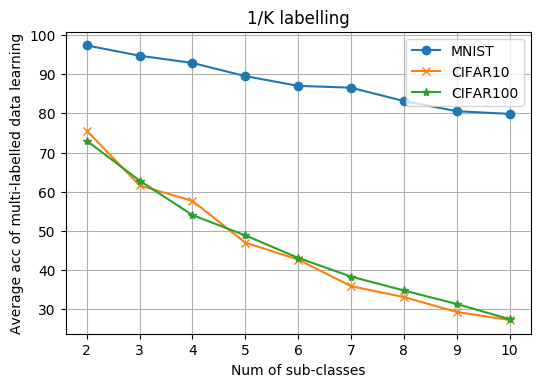

In [19]:
plt.figure(dpi = 100)
plt.title("1/K labelling")
plt.plot([i for i in range(2, 11)], results, marker = "o", label = "MNIST")
plt.plot([i for i in range(2, 11)], results2, marker = "x", label = "CIFAR10")
plt.plot([i for i in range(2, 11)], results3, marker = "*", label = "CIFAR100")
plt.xlabel("Num of sub-classes")
plt.ylabel("Average acc of multi-labelled data learning")	
plt.legend(loc = "upper right")
plt.grid(True)

In [20]:
print(f"MNIST (10回の平均)\n{results}")
print(f"CIFAR10 (遅いので3回の平均)\n{results2}")
print(f"CIFAR100 (10回の平均)\n{results3}")

MNIST (10回の平均)
[97.36281997 94.74324793 92.88411133 89.52189082 87.0354047  86.5668632
 83.15581019 80.56001975 79.87      ]
CIFAR10 (遅いので3回の平均)
[75.58333333 61.57777778 57.625      46.96       42.65       35.83333333
 33.05416667 29.24814815 27.19      ]
CIFAR100 (10回の平均)
[73.         62.8        54.         48.82       43.06666667 38.28571429
 34.7375     31.28888889 27.4       ]


In [21]:
oneKth_results = [results, results2, results3]

In [23]:
oneKth_results

[array([97.36281997, 94.74324793, 92.88411133, 89.52189082, 87.0354047 ,
        86.5668632 , 83.15581019, 80.56001975, 79.87      ]),
 array([75.58333333, 61.57777778, 57.625     , 46.96      , 42.65      ,
        35.83333333, 33.05416667, 29.24814815, 27.19      ]),
 array([73.        , 62.8       , 54.        , 48.82      , 43.06666667,
        38.28571429, 34.7375    , 31.28888889, 27.4       ])]